In [1]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import sqlite3
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
import pickle

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [ ]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Read the dataset - Amazon fine food reviews
con=sqlite3.connect("/content/drive/My Drive/amazondatabase.sqlite")
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews""", con) 
filtered_data.to_csv("review.csv")

In [ ]:
data=pd.read_csv("review.csv")

In [ ]:
reviews=data[["Text","Score"]]


In [ ]:
len(reviews)

568454

checking whether the text column contain null value or not

In [ ]:
#get only 2 columns - Text, Score
#drop the NAN values

In [ ]:
print("Null value in the dataset:",len(reviews[reviews.isnull().any(axis=1)]))

Null value in the dataset: 0


In [ ]:
#if score> 3, set score = 1
#if score<=2, set score = 0
#if score == 3, remove the rows. 

In [ ]:
reviews=reviews[reviews["Score"]!=3]

In [ ]:
reviews.shape

(525814, 2)

In [ ]:
reviews.shape

(525814, 2)

In [ ]:
def partition(x):
    if x<=2:
        return 0
    else:
        return 1
posneg=reviews["Score"].map(partition)
reviews["Score"]=posneg


In [ ]:
reviews.shape

(525814, 2)

<font size=4>Grader function 2 </font>

In [ ]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [ ]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]

In [ ]:
reviews.shape

(234088, 3)

In [ ]:
#remove HTML from the Text column and save in the Text column only

In [ ]:
stop_words=set(stopwords.words("english"))

def text_preprocessing(text,column,Index):
     if type(text) is not int:
        string=""
        text=re.sub('[^a-zA-Z0-9\n]',' ',text)
        text=re.sub('\s+',' ',text)
        text=text.lower()
        text=re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]"," ",text)
        pattern = re.compile('\W')
        text= re.sub(pattern, ' ', text)
        text = BeautifulSoup(text,"lxml").text
        for word in text.split():
            if word not in stop_words:
                string+=word+" "
     reviews[column][Index]=string

In [ ]:
for index,rows in reviews.iterrows():
    if type(rows['Text']) is str:
        text_preprocessing(rows["Text"],column="Text",Index=index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
len(reviews)

234088

In [ ]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocess.csv', index=False)

In [3]:
df=pd.read_csv("/content/drive/My Drive/preprocess.csv")
df.head()

,Text,Score,len
0,bought several vitality canned dog food produc...,1,48
1,product arrived labeled jumbo salted peanuts p...,0,31
2,looking secret ingredient robitussin believe f...,0,41
3,great taffy great price wide assortment yummy ...,1,27
4,saltwater taffy great flavors soft chewy candy...,1,49


In [ ]:
len(df)

234088

Train Test data split

In [7]:
x=df.drop(["Score","len"],axis=1)
y=df["Score"]

In [8]:
X_train,X_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=33)

In [9]:
pickle.dump((y_train),open('ytr','wb'))
pickle.dump((y_test),open('yte','wb'))

In [3]:
y_train = pickle.load(open("/content/drive/My Drive/ytr", 'rb')) 
y_test = pickle.load(open("/content/drive/My Drive/yte", 'rb')) 

In [ ]:
X_train.shape,X_test.shape

((187270, 1), (46818, 1))

In [ ]:
#plot bar graphs of y_train and y_test

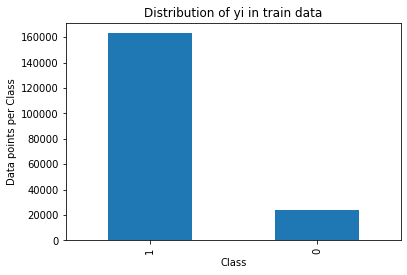

In [ ]:
Y_train.value_counts().plot(kind="bar",title="Score")
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.show()

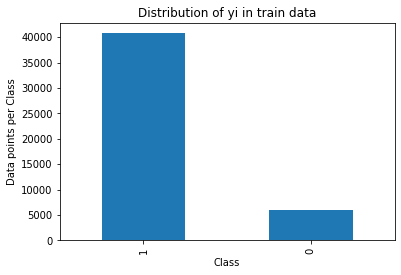

In [ ]:
Y_test.value_counts().plot(kind="bar",title="Score")
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.show()

<pre><font size=6>Part-2: Creating BERT Model</font> 

 </pre>

In [4]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [ ]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 55)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
bert_model.output

<tf.Tensor 'keras_layer/Identity:0' shape=(None, 768) dtype=float32>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [5]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [6]:
from google.colab import files
files=files.upload()

Saving tokenization.py to tokenization (2).py


In [7]:
! pip install sentencepiece
import tokenization 

In [8]:
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case)

In [ ]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation

<font size=4>Grader function 3 </font>

In [ ]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

In [ ]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

# Train sequence tokens,masking and segment

In [ ]:
X_train_tokens=[]
X_train_mask=[]
X_train_segment=[]
max_seq_length=55
token_names=[]
for i in range(len(X_train)):
  tokens=tokenizer.tokenize(X_train.values[i][0])
  tokens=tokens[0:(max_seq_length-2)]
  tokens=["[CLS]",*tokens]
  padded_tokens=tokens+["[PAD]" for i in range((max_seq_length-1)-len(tokens))]
  padded_tokens=[*padded_tokens,"[SEP]"]
  mask=[ 1 if token != '[PAD]' else 0 for token in padded_tokens ]
  token_names.append(tokens)
  segment=np.array([0]*max_seq_length)
  X_train_mask.append(mask)
  X_train_tokens.append(np.array(tokenizer.convert_tokens_to_ids(padded_tokens)))
  X_train_segment.append(segment)

X_train_tokens=np.asarray(X_train_tokens)
X_train_mask=np.asarray(X_train_mask)
X_train_segment=np.asarray(X_train_segment)



# Test sequence tokens,masking and segemnt

In [ ]:
X_test_tokens=[]
X_test_mask=[]
X_test_segment=[]
max_seq_length=55
token_names=[]
for i in range(len(X_test)):
  tokens=tokenizer.tokenize(X_test.values[i][0])
  tokens=tokens[0:(max_seq_length-2)]
  tokens=["[CLS]",*tokens]
  padded_tokens=tokens+["[PAD]" for i in range((max_seq_length-1)-len(tokens))]
  padded_tokens=[*padded_tokens,"[SEP]"]
  mask=[ 1 if token != '[PAD]' else 0 for token in padded_tokens ]
  token_names.append(tokens)
  segment=np.array([0]*max_seq_length)
  X_test_mask.append(mask)
  X_test_tokens.append(np.array(tokenizer.convert_tokens_to_ids(padded_tokens)))
  X_test_segment.append(segment)

X_test_tokens=np.asarray(X_test_tokens)
X_test_mask=np.asarray(X_test_mask)
X_test_segment=np.asarray(X_test_segment)


#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [ ]:
import pickle

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [ ]:
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("/content/drive/My Drive/train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("/content/drive/My Drive/test_data.pkl", 'rb')) 

<font size=4>Grader function 4 </font>

In [ ]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [ ]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [ ]:
bert_model.input

In [ ]:
bert_model.output

In [ ]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
X_train_pooled_output=bert_model.predict([[X_train_tokens],[X_train_mask],[X_train_segment]])

In [ ]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([[X_test_tokens],[X_test_mask],[X_test_segment]])

In [ ]:
##save all your results to disk so that, no need to run all again. 
import pickle
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [9]:
import pickle
X_train_pooled_output, X_test_pooled_output= pickle.load(open('/content/drive/My Drive/final_output.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [ ]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric.</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [10]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model
%load_ext tensorboard
from sklearn.metrics import roc_auc_score

# call back Definition

In [11]:
class auc(tf.keras.callbacks.Callback):
 def __init__(self,training_data,validation_data):
     self.x = training_data[0]
     self.y = training_data[1]
     self.x_val = validation_data[0]
     self.y_val = validation_data[1]

 def on_epoch_end(self, epoch, logs={}):
     y_pred = self.model.predict(self.x)
     roc = roc_auc_score(self.y, y_pred)
     y_pred_val = self.model.predict(self.x_val)
     roc_val = roc_auc_score(self.y_val, y_pred_val)
     print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))))

In [12]:
Auc= auc(training_data=(X_train_pooled_output, y_train),
                  validation_data=(X_test_pooled_output, y_test))

In [13]:
log_dir="logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,write_grads=True)

In [14]:
callback=[Auc,tensorboard_callback]

In [ ]:
!rm -rf ./logs/ 

# Model Implementation

In [15]:
##create an NN and 
input=Input(shape=(768,))

dense1=Dense(128,activation="relu",kernel_initializer="glorot_normal")(input)

dense2=Dense(64,activation="relu",kernel_initializer="glorot_normal")(dense1)

dense3=Dense(32,activation="relu",kernel_initializer="glorot_normal")(dense2)

dense4=Dense(16,activation="relu",kernel_initializer="glorot_normal")(dense3)

output=Dense(1,activation="sigmoid")(dense4)
model1=Model(inputs=input,outputs=output)

In [16]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss= 'binary_crossentropy',metrics=["accuracy"])
model1.fit(X_train_pooled_output,y_train,epochs=10,validation_data=(X_test_pooled_output,y_test),batch_size=1000,callbacks=callback)           

Epoch 1/10
roc-auc: 0.8602 - roc-auc_val: 0.863
188/188 [==============================] - 10s 51ms/step - loss: 0.3535 - accuracy: 0.8694 - val_loss: 0.2780 - val_accuracy: 0.8856
Epoch 2/10
roc-auc: 0.878 - roc-auc_val: 0.8801
188/188 [==============================] - 9s 49ms/step - loss: 0.2819 - accuracy: 0.8860 - val_loss: 0.2808 - val_accuracy: 0.8937
Epoch 3/10
roc-auc: 0.8845 - roc-auc_val: 0.8852
188/188 [==============================] - 9s 49ms/step - loss: 0.2668 - accuracy: 0.8920 - val_loss: 0.2554 - val_accuracy: 0.8970
Epoch 4/10
roc-auc: 0.8862 - roc-auc_val: 0.8873
188/188 [==============================] - 9s 50ms/step - loss: 0.2700 - accuracy: 0.8916 - val_loss: 0.2667 - val_accuracy: 0.8925
Epoch 5/10
roc-auc: 0.8897 - roc-auc_val: 0.8906
188/188 [==============================] - 9s 48ms/step - loss: 0.2610 - accuracy: 0.8949 - val_loss: 0.2490 - val_accuracy: 0.9005
Epoch 6/10
roc-auc: 0.892 - roc-auc_val: 0.8927
188/188 [==============================] - 9s 49

# plotting Metrics and Loss graph

Text(0.5, 1.0, 'Training and Validation auc')

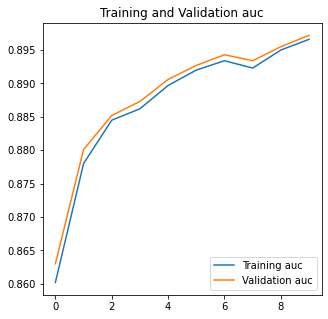

In [29]:
import matplotlib.pyplot as plt
auc=[0.8602,0.878,0.8845,0.8862,0.8897,0.892,0.8934,0.8923,0.895,0.8966]
val_auc=[0.863,0.8801,0.8852,0.8873,0.8906,0.8927,0.8943,0.8934,0.8955,0.8972]
plt.figure(figsize=(5,5))
epochs_range=range(10)
plt.plot(epochs_range, auc, label='Training auc')
plt.plot(epochs_range, val_auc, label='Validation auc')
plt.legend(loc='lower right')
plt.title('Training and Validation auc')

Text(0.5, 1.0, 'Training and Validation loss')

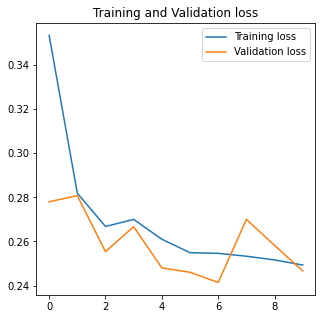

In [32]:
import matplotlib.pyplot as plt
loss=[0.3535,0.2819,0.2668,0.2700,0.2610,0.2549,0.2546,0.2533,0.2516,0.2493]
val_loss=[0.2780,0.2808,0.2554,0.2667,0.2480,0.2460,0.2414,0.27,0.2582,0.2466]
plt.figure(figsize=(5,5))
epochs_range=range(10)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

Obsevation:

1.The above AUC graph show there is no overfitting between train and test data it increase the AUC when epoch also increases
2. Training the text classification model with pretrained bert shows more accuracy and AUC.
3. The loss graph show thus train data reduces its loss smoothly whereas the the test loss having some noise at initial epoch and when we train more epoch the test loss reduces smoothly. Here i just trained with 10 epochs after ten epoch its show smooth reduce curve of test loss.

# Bert pipline

# Load the Dataset

In [17]:
test_df=pd.read_csv("/content/drive/My Drive/test (1).csv")

In [18]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# step2 Remove HTML tags

In [19]:
stop_words=set(stopwords.words("english"))

def text_preprocessing(text,column,Index):
     if type(text) is not int:
        string=""
        text=re.sub('[^a-zA-Z0-9\n]',' ',text)
        text=re.sub('\s+',' ',text)
        text=text.lower()
        text=re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]"," ",text)
        pattern = re.compile('\W')
        text= re.sub(pattern, ' ', text)
        text = BeautifulSoup(text,"lxml").text
        for word in text.split():
            if word not in stop_words:
                string+=word+" "
     test_df[column][Index]=string

In [20]:
for index,rows in test_df.iterrows():
    if type(rows['Text']) is str:
        text_preprocessing(rows["Text"],column="Text",Index=index)

# step 3 Create tokens,mask array and segment array

In [21]:
X_test_tokens=[]
X_test_mask=[]
X_test_segment=[]
max_seq_length=55
token_names=[]
for i in range(len(test_df)):
  tokens=tokenizer.tokenize(test_df.values[i][0])
  tokens=tokens[0:(max_seq_length-2)]
  tokens=["[CLS]",*tokens]
  padded_tokens=tokens+["[PAD]" for i in range((max_seq_length-1)-len(tokens))]
  padded_tokens=[*padded_tokens,"[SEP]"]
  mask=[ 1 if token != '[PAD]' else 0 for token in padded_tokens ]
  token_names.append(tokens)
  segment=np.array([0]*max_seq_length)
  X_test_mask.append(mask)
  X_test_tokens.append(np.array(tokenizer.convert_tokens_to_ids(padded_tokens)))
  X_test_segment.append(segment)

X_test_tokens=np.asarray(X_test_tokens)
X_test_mask=np.asarray(X_test_mask)
X_test_segment=np.asarray(X_test_segment)

# Tokens are pre-trained to bert model

In [22]:
X_test_pooled_output=bert_model.predict([[X_test_tokens],[X_test_mask],[X_test_segment]])

# Predict the ouput by the Neural network

In [23]:
predict=model1.predict(X_test_pooled_output)

In [24]:
predict = predict[:,0]
predict= np.where(predict > 0.5, 1, 0)

In [25]:
predict

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [35]:
import collections
occurance=collections.Counter(predict)
print("The occurance of class label 0:",occurance[0])
print("The occurance of class label 1:",occurance[1])

The occurance of class label 0: 18
The occurance of class label 1: 334


# Step by step followed :


1.Load the Amazon Food Review Dataset.

2.perform some statistical data analysis and done some text preprocessing by removing special characters and HTML tags because the data is taken from amazon web api.

3.After preprocess we get clean text and split the data into train and test split.

4.And perform tokenization,masking,seq padding of each document in corpus. 

5.Taking the input as sequence pading,masking,segment and feed this input to bert pre trained model.

6.And the output of bert pretrained model we got xtrained pooled output ans xtest pooled output.

7.This bert output is feed as input to our Neural network with dense layer to classify whether it is a positive review or negative review.

8.Finally we got 0.8972 AUC when i trained the model with 10 epochs.

